# Categorical embedding

## Libraries

In [33]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from keras import metrics
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Embedding,Reshape, Concatenate
from itertools import chain

In [34]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
	raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

## Training data

In [35]:
data = pd.read_csv("./data/full_RASFF_DATA.csv", sep=";", header=0, index_col=0)

data.head(3)

,CLASSIF,DATE_CASE,REF,NOT_COUNTRY,SUBJET,PROD_CAT,TYPE,RISK_DECISION,ACTION_TAKEN,DISTRIBUTION_STAT,PRODUCT,HAZARDS,HAZARDS_CAT,COUNT_ORIGEN,COUNT_DESTIN,COUNT_CONCERN,NUMBER
0,alert,2020-10-16,2020.4364,France,Listeria monocytogenes (presence) in ham trimm...,meat and meat products (other than poultry),food,serious,recall from consumers,distribution to other member countries,ham trimmings,listeria monocytogenes,microbial contaminants (other),France,"Czech Republic,United Kingdom",NaN,NaN
1,border rejection,2020-10-16,2020.4349,Bulgaria,prochloraz (0.696 mg/kg - ppm) in mandarins fr...,fruits and vegetables,food,serious,destruction,product not (yet) placed on the market,mandarins,prochloraz,pesticide residues,Turkey,NaN,Bulgaria,NaN
2,border rejection,2020-10-16,2020.4350,Bulgaria,fenvalerate (0.357 mg/kg - ppm) in chilled man...,fruits and vegetables,food,serious,re-dispatch,product not (yet) placed on the market,chilled mandarins,fenvalerate,pesticide residues,Turkey,NaN,Bulgaria,NaN


## Basic pre-processing

In [36]:
data.DATE_CASE = data.DATE_CASE.astype(str)
data.HAZARDS_CAT = data.HAZARDS_CAT.astype(str)
data.COUNT_DESTIN = data.COUNT_DESTIN.astype(str)
data.COUNT_CONCERN = data.COUNT_CONCERN.astype(str)

data.dropna(subset=data.columns[[1, 3, 5, 8, 9, 12, 13]], inplace=True)

data = data.sample(frac=1)

In [37]:
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

In [38]:
lens = data['HAZARDS_CAT'].str.split(',').map(len)
split1 = pd.DataFrame({'DATE_CASE': np.repeat(data['DATE_CASE'], lens),
                    'NOT_COUNTRY': np.repeat(data['NOT_COUNTRY'], lens),
                    'PROD_CAT': np.repeat(data['PROD_CAT'], lens),
                    'TYPE': np.repeat(data['TYPE'], lens),
                    'RISK_DECISION': np.repeat(data['RISK_DECISION'], lens),
                    'ACTION_TAKEN': np.repeat(data['ACTION_TAKEN'], lens),
                    'DISTRIBUTION_STAT': np.repeat(data['DISTRIBUTION_STAT'], lens),
                    'HAZARDS_CAT': chainer(data['HAZARDS_CAT']),
                    'COUNT_ORIGEN': np.repeat(data['COUNT_ORIGEN'], lens),
                    'COUNT_DESTIN': np.repeat(data['COUNT_DESTIN'], lens),
                    'COUNT_CONCERN': np.repeat(data['COUNT_CONCERN'], lens)})

lens = split1['COUNT_ORIGEN'].str.split(',').map(len)
split2 = pd.DataFrame({'DATE_CASE': np.repeat(split1['DATE_CASE'], lens),
                    'NOT_COUNTRY': np.repeat(split1['NOT_COUNTRY'], lens),
                    'PROD_CAT': np.repeat(split1['PROD_CAT'], lens),
                    'TYPE': np.repeat(split1['TYPE'], lens),
                    'RISK_DECISION': np.repeat(split1['RISK_DECISION'], lens),
                    'ACTION_TAKEN': np.repeat(split1['ACTION_TAKEN'], lens),
                    'DISTRIBUTION_STAT': np.repeat(split1['DISTRIBUTION_STAT'], lens),
                    'HAZARDS_CAT': np.repeat(split1['HAZARDS_CAT'], lens),
                    'COUNT_ORIGEN': chainer(split1['COUNT_ORIGEN']),
                    'COUNT_DESTIN': np.repeat(split1['COUNT_DESTIN'], lens),
                    'COUNT_CONCERN': np.repeat(split1['COUNT_CONCERN'], lens)})

lens = split2['COUNT_DESTIN'].str.split(',').map(len)
split3 = pd.DataFrame({'DATE_CASE': np.repeat(split2['DATE_CASE'], lens),
                    'NOT_COUNTRY': np.repeat(split2['NOT_COUNTRY'], lens),
                    'PROD_CAT': np.repeat(split2['PROD_CAT'], lens),
                    'TYPE': np.repeat(split2['TYPE'], lens),
                    'RISK_DECISION': np.repeat(split2['RISK_DECISION'], lens),
                    'ACTION_TAKEN': np.repeat(split2['ACTION_TAKEN'], lens),
                    'DISTRIBUTION_STAT': np.repeat(split2['DISTRIBUTION_STAT'], lens),
                    'HAZARDS_CAT': np.repeat(split2['HAZARDS_CAT'], lens),
                    'COUNT_ORIGEN': np.repeat(split2['COUNT_ORIGEN'], lens),
                    'COUNT_DESTIN': chainer(split2['COUNT_DESTIN']),
                    'COUNT_CONCERN': np.repeat(split2['COUNT_CONCERN'], lens)})

lens = split3['COUNT_CONCERN'].str.split(',').map(len)
split4 = pd.DataFrame({'DATE_CASE': np.repeat(split3['DATE_CASE'], lens),
                    'NOT_COUNTRY': np.repeat(split3['NOT_COUNTRY'], lens),
                    'PROD_CAT': np.repeat(split3['PROD_CAT'], lens),
                    'TYPE': np.repeat(split3['TYPE'], lens),
                    'RISK_DECISION': np.repeat(split3['RISK_DECISION'], lens),
                    'ACTION_TAKEN': np.repeat(split3['ACTION_TAKEN'], lens),
                    'DISTRIBUTION_STAT': np.repeat(split3['DISTRIBUTION_STAT'], lens),
                    'HAZARDS_CAT': np.repeat(split3['HAZARDS_CAT'], lens),
                    'COUNT_ORIGEN': np.repeat(split3['COUNT_ORIGEN'], lens),
                    'COUNT_DESTIN': np.repeat(split3['COUNT_DESTIN'], lens),
                    'COUNT_CONCERN': chainer(split3['COUNT_CONCERN'])})

split4 = split4.reset_index(drop = True)
split4 = split4.dropna(subset = ['DATE_CASE'])

data = split4.copy()

In [39]:
data.head(3)

,DATE_CASE,NOT_COUNTRY,PROD_CAT,TYPE,RISK_DECISION,ACTION_TAKEN,DISTRIBUTION_STAT,HAZARDS_CAT,COUNT_ORIGEN,COUNT_DESTIN,COUNT_CONCERN
0,2004-08-05,Italy,poultry meat and poultry meat products,food,undecided,,product past use-by date,pathogenic micro-organisms,United Kingdom,Italy,
1,2004-11-22,Italy,crustaceans and products thereof,food,undecided,destruction,product past use-by date,food additives and flavourings,France,Italy,
2,2012-04-11,Portugal,fruits and vegetables,food,undecided,destruction,no distribution,pesticide residues,South Africa,nan,Portugal


## Features selection

In [40]:
categorical_vars = [0, 1, 6, 8]
target_vars = [2]

X = data.iloc[:, categorical_vars]
Y = data.iloc[:, target_vars]

In [41]:
ency = OneHotEncoder(handle_unknown="ignore", sparse=False)

ency.fit(Y.values)

OneHotEncoder(handle_unknown='ignore', sparse=False)

## Split train-val-test

In [42]:
# x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, shuffle=True)

train_mask = (data.DATE_CASE >= "2004-01-01") & (data.DATE_CASE <= "2018-12-31")
test_mask = (data.DATE_CASE >= "2019-01-01") & (data.DATE_CASE <= "2019-12-31")

x_training_data = X.loc[train_mask]
y_training_data = Y.loc[train_mask]
x_test_data = X.loc[test_mask]
y_test_data = Y.loc[test_mask]

y_training_data = ency.transform(y_training_data.values)
y_test_data = ency.transform(y_test_data.values)

x_training_data, x_val_data, y_training_data, y_val_data = train_test_split(x_training_data, y_training_data, test_size=0.2, random_state=42, shuffle=True)

## Coding and conversion to lists for beign able to introduce it into the model

In [43]:
categorical_vars = data.iloc[:, [0, 1, 6, 8]].columns

def preproc(X_train, X_test, X_val):
    input_list_train = []
    input_list_test = []
    input_list_testval = []
    
    for c in categorical_vars:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
        input_list_testval.append(X_val[c].map(val_map).fillna(0).values)

    return input_list_train, input_list_test,input_list_testval

In [44]:
input_list_train, input_list_test, input_list_testval = preproc(x_training_data, x_test_data, x_val_data)

## Metrics definition

In [45]:
def top_1_categorical_accuracy(y_true, y_pred):
	return metrics.top_k_categorical_accuracy(y_true, y_pred, k=1)

def top_2_categorical_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3_categorical_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

## Embeddings + MLP Models (cases 1 and 3)

In [46]:
input_models = []
output_embeddings = []

for categorical_var in categorical_vars:
    cat_emb_name = categorical_var.replace(" ", "") + "_Embedding"
    input_name = "Input_" + categorical_var.replace(" ", "")
    no_of_unique_cat = x_training_data[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50))
   
    input_model = Input(shape=(1, ), name=input_name)
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size, ))(output_model)    
    
    input_models.append(input_model)
    output_embeddings.append(output_model)
  
output = Concatenate()(output_embeddings)
output = Dense(2048,activation="relu")(output)
output = Dropout(0.3)(output)
output = Dense(1024,activation="relu")(output)
output = Dropout(0.2)(output)
output = Dense(512,activation="relu")(output)
output = Dropout(0.2)(output)
output = Dense(43, activation="softmax")(output)

model = Model(inputs=input_models, outputs=output)

In [47]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", top_1_categorical_accuracy,top_2_categorical_accuracy,top_3_categorical_accuracy])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_DATE_CASE (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_NOT_COUNTRY (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_DISTRIBUTION_STAT (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_COUNT_ORIGEN (InputLayer) [(None, 1)]          0                                            
____________________________________________________________________________________________

In [48]:
# REVIEW: No validation data has been provided
 
# hist = model.fit(input_list_train, y_training_data, validation_data=(input_list_test, y_test_data), epochs=5 , batch_size=64, verbose=1)
hist = model.fit(input_list_train, y_training_data, validation_data=(input_list_testval, y_val_data), epochs=5, batch_size=64, verbose=1)

Epoch 1/5
1647/1647 [==============================] - 76s 45ms/step - loss: 1.6158 - accuracy: 0.5701 - top_1_categorical_accuracy: 0.5701 - top_2_categorical_accuracy: 0.6768 - top_3_categorical_accuracy: 0.7365 - val_loss: 1.1767 - val_accuracy: 0.6823 - val_top_1_categorical_accuracy: 0.6823 - val_top_2_categorical_accuracy: 0.7774 - val_top_3_categorical_accuracy: 0.8247
Epoch 2/5
1647/1647 [==============================] - 62s 38ms/step - loss: 0.9818 - accuracy: 0.7355 - top_1_categorical_accuracy: 0.7355 - top_2_categorical_accuracy: 0.8235 - top_3_categorical_accuracy: 0.8655 - val_loss: 0.9421 - val_accuracy: 0.7537 - val_top_1_categorical_accuracy: 0.7537 - val_top_2_categorical_accuracy: 0.8323 - val_top_3_categorical_accuracy: 0.8684
Epoch 3/5
1647/1647 [==============================] - 79s 48ms/step - loss: 0.7078 - accuracy: 0.8056 - top_1_categorical_accuracy: 0.8056 - top_2_categorical_accuracy: 0.8808 - top_3_categorical_accuracy: 0.9122 - val_loss: 0.8342 - val_acc

In [49]:
def get_specifity(y_actual, y_pred):
    TN = []
    FP = []

    for index ,_id in enumerate(np.union1d(y_actual, y_pred)):
        FP.append(0)
        TN.append(0)

        for i in range(len(y_pred)):
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1

    TN = sum(TN)
    FP = sum(FP)

    return TN/(TN + FP)

471/471 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - top_1_categorical_accuracy: 0.0000e+00 - top_2_categorical_accuracy: 0.0000e+00 - top_3_categorical_accuracy: 0.0000e+00
Loss: 0.0
Accuracy: 0.0
Top-1 Accuracy: 0.0
Top-2 Accuracy: 0.0
Top-3 Accuracy: 0.0
- Accuracy: 24.02%
Specifity: 91.71%
Sensitivity: 12.96%
Precision: 14.55%
              precision    recall  f1-score   support

           0       0.01      0.28      0.02        29
           2       0.00      1.00      0.00         0
           3       0.14      0.01      0.02       189
           4       1.00      0.00      0.00        49
           5       0.09      0.17      0.11       715
           6       0.11      0.04      0.06       336
           7       0.00      0.00      0.00        31
           8       0.09      0.01      0.02       396
           9       0.09      0.15      0.11       103
          10       0.82      0.33      0.47      1652
          11       0.00   

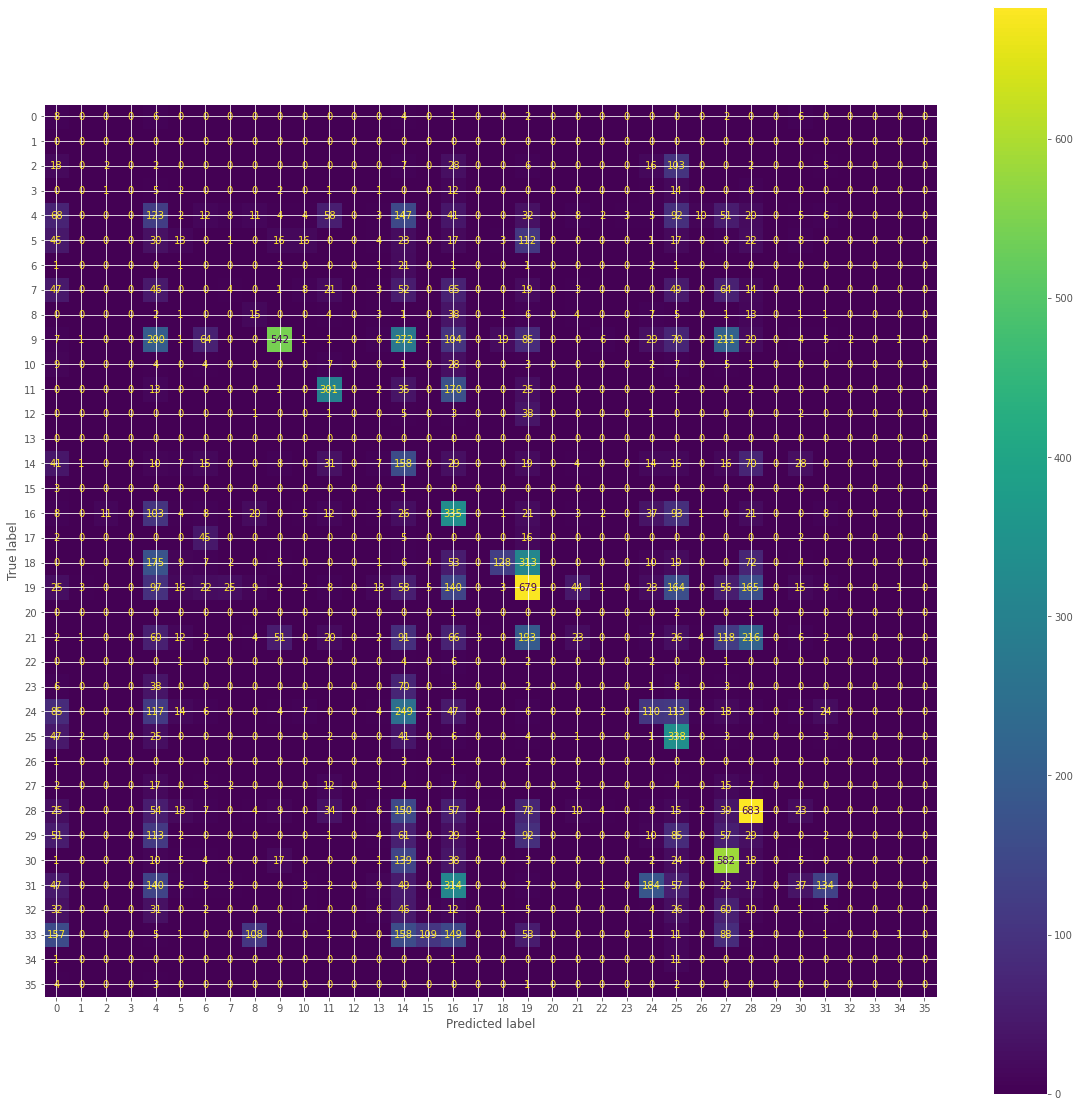

In [50]:
def get_metrics():
	result = model.predict(input_list_test, batch_size=64)
	result = np.argmax(result, axis=-1)

	valid_loss, valid_accuracy, acc1, acc2, acc3 = model.evaluate(input_list_test)

	print("Loss:", valid_loss)
	print("Accuracy:", valid_accuracy)
	print("Top-1 Accuracy:", acc1)
	print("Top-2 Accuracy:", acc2)
	print("Top-3 Accuracy:", acc3)
	print(f"- Accuracy: {round(accuracy_score(np.argmax(y_test_data, axis=-1), result)*100, 2)}%")
	print(f"Specifity: {round(get_specifity(np.argmax(y_test_data, axis=-1), result)*100, 2)}%")
	print(f"Sensitivity: {round(recall_score(np.argmax(y_test_data, axis=-1), result, average='macro', zero_division=0)*100, 2)}%")
	print(f"Precision: {round(precision_score(np.argmax(y_test_data, axis=-1), result, average='macro', zero_division=0)*100, 2)}%")

	print(classification_report(np.argmax(y_test_data, axis=-1), result, zero_division=True))

	cm = confusion_matrix(np.argmax(y_test_data, axis=-1), result)
	cm = ConfusionMatrixDisplay(confusion_matrix=cm)

	fig, ax = plt.subplots(figsize=(20, 20))
	cm.plot(ax=ax)

	plt.show()

get_metrics()

In [ ]:
# result = model.predict(input_list_test, batch_size=64)
# result = np.argmax(result, axis=1)

# valid_loss, valid_accuracy, acc1, acc2, acc3 = model.evaluate(input_list_test)

In [ ]:
# print("Loss:", valid_loss)
# print("Accuracy:", valid_accuracy)
# print("Top-1 Accuracy:", acc1)
# print("Top-2 Accuracy:", acc2)
# print("Top-3 Accuracy:", acc3)

In [ ]:
# print(classification_report(np.argmax(y_test_data, axis=-1), result, zero_division=True))

In [ ]:
# cm = confusion_matrix(np.argmax(y_test_data, axis=-1), result)
# cm = ConfusionMatrixDisplay(confusion_matrix=cm)

# fig, ax = plt.subplots(figsize=(20, 20))
# cm.plot(ax=ax)

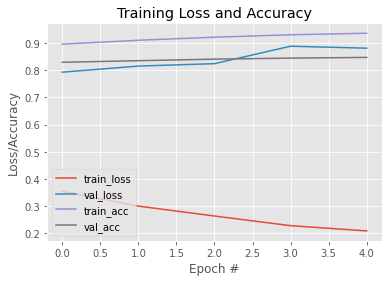

In [31]:
N = 5

plt.style.use("ggplot")

plt.figure()

plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()

In [ ]:
historials = []
evaluations = []

for i in range (1, 6):
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", top_1_categorical_accuracy, top_2_categorical_accuracy, top_3_categorical_accuracy])
    
    hist = model.fit(input_list_train, y_training_data, validation_data=(input_list_testval, y_val_data), epochs=25, batch_size=64, verbose=0)
    historials.append(hist)
    
    evaluation = model.evaluate(x=input_list_test, y=y_test_data)
    evaluations.append(evaluation)
    
    model.save("model" + str(i) + ".h5")

    get_metrics()

    print("\n\n-----------------------\n")